### Import Packages

In [1]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile

from sklearn.model_selection import train_test_split

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import torchsummary

### Global attributes

In [2]:
mixed_dir = "../mixed_data/"
clean_dir = "../clean_data/"
nature_mixed_dir = "../classified_sound_1115/nature/mixed/"
nature_clean_dir = "../classified_sound_1115/nature/clean/"

### Preprocess Data

In [3]:
# MelSpectrogram參數
n_mels = 128                # 保持 Mel 頻譜圖的解析度
n_fft = 1024                # 提高 FFT 窗口大小以適配更多信號頻率
hop_length = 512            # 保持 hop_length 為 n_fft 的一半
win_length = 1024           # 窗口大小與 n_fft 保持一致（或設為 None 使用默認值）
sample_rate = 16000         # 採樣率保持不變，適合語音處理
f_max = sample_rate // 2    # 預設為 Nyquist 頻率，即 8000 Hz
duration = 5                # 音頻時長為 5 秒

In [4]:
import os
import torch
import librosa
import numpy as np
import soundfile as sf
from alive_progress import alive_bar
import time

# def save_spectrogram_as_npy(spectrogram, save_path):
#     """Save mel spectrogram as a NumPy array."""
#     np.save(save_path, spectrogram)  # Save as .npy file

# def sound_to_spectrogram(mixed_dir, clean_dir, sample_rate, duration, n_mels):
    
#     length = len([f for f in os.listdir(mixed_dir) if f != ".gitkeep"])
    
#     # print(f"Loading {length} files...")

#     with alive_bar(length, force_tty=True) as bar:
#         for filename in sorted(os.listdir(mixed_dir)):
#             if ".gitkeep" in filename:
#                 continue
#             try:
#                 # 使用完整路徑
#                 mixed_path = os.path.join(mixed_dir, filename)
#                 clean_path = os.path.join(clean_dir, filename)
                
#                 # 使用 soundfile 替代 librosa.load
#                 mixed_waveform, sr = sf.read(mixed_path)
#                 clean_waveform, sr = sf.read(clean_path)
                
#                 # 如果採樣率不匹配，進行重採樣
#                 if sr != sample_rate:
#                     mixed_waveform = librosa.resample(mixed_waveform, orig_sr=sr, target_sr=sample_rate)
#                     clean_waveform = librosa.resample(clean_waveform, orig_sr=sr, target_sr=sample_rate)
                
#                 # 如果指定了持續時間，裁剪音頻
#                 if duration:
#                     samples = int(duration * sample_rate)
#                     mixed_waveform = mixed_waveform[:samples]
#                     clean_waveform = clean_waveform[:samples]
                
#                 # 生成梅爾頻譜圖
#                 mixed_mel_spectrogram = librosa.feature.melspectrogram(
#                     y=mixed_waveform,
#                     sr=sample_rate,
#                     n_fft=n_fft,
#                     hop_length=hop_length,
#                     n_mels=n_mels
#                 )
#                 clean_mel_spectrogram = librosa.feature.melspectrogram(
#                     y=clean_waveform,
#                     sr=sample_rate,
#                     n_fft=n_fft,
#                     hop_length=hop_length,
#                     n_mels=n_mels
#                 )

#                 # 轉換為分貝刻度
#                 mixed_mel_spectrogram_db = librosa.power_to_db(
#                     mixed_mel_spectrogram, 
#                     ref=np.max, 
#                     amin=1e-10  # 避免log(0)
#                 )
#                 clean_mel_spectrogram_db = librosa.power_to_db(
#                     clean_mel_spectrogram, 
#                     ref=np.max, 
#                     amin=1e-10
#                 )
                
#                 # Save spectrograms as .npy files
#                 mixed_npy_path = os.path.join("../nature/mixed/", f"{filename[-4]}.npy")
#                 clean_npy_path = os.path.join("../nature/clean/", f"{filename[-4]}.npy")

#                 save_spectrogram_as_npy(mixed_mel_spectrogram_db, mixed_npy_path)
#                 save_spectrogram_as_npy(clean_mel_spectrogram_db, clean_npy_path)
                
#                 bar()
                
#             except Exception as e:
#                 print(f"Error processing file {filename}: {str(e)}")
#                 continue
            
# sound_to_spectrogram(nature_mixed_dir, nature_clean_dir, sample_rate, duration, n_mels)


In [5]:
def load_spectrogram_from_npy(mixed_dir, clean_dir):
    """Load mel spectrogram from a NumPy file."""
    mixed_mel_spectrograms = []
    clean_mel_spectrograms = []
    
    length = len(os.listdir(clean_dir))
    
    # print(f"Loading {length} files...")

    with alive_bar(length, force_tty=True) as bar:
        for filename in sorted(os.listdir(clean_dir)):
            if ".gitkeep" in filename:
                continue
            try:
                # 使用完整路徑
                mixed_path = os.path.join(mixed_dir, filename)
                clean_path = os.path.join(clean_dir, filename)
                
                mixed_mel_spectrogram_db = np.load(mixed_path)
                clean_mel_spectrogram_db = np.load(clean_path)

                # # 轉換為 PyTorch tensor 並添加通道維度
                mixed_mel_tensor = torch.tensor(mixed_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                clean_mel_tensor = torch.tensor(clean_mel_spectrogram_db, dtype=torch.float32).squeeze().unsqueeze(0)
                
                mixed_mel_spectrograms.append(mixed_mel_tensor)
                clean_mel_spectrograms.append(clean_mel_tensor)
                
                bar()
                
            except Exception as e:
                print(f"Error load file {filename}: {str(e)}")
                continue

    return mixed_mel_spectrograms, clean_mel_spectrograms

In [6]:
mixed_mel_spectrograms, clean_mel_spectrograms = load_spectrogram_from_npy("../nature/mixed/", "../nature/clean/")
mixed_mel_spectrograms_train, mixed_mel_spectrograms_val, clean_mel_spectrograms_train, clean_mel_spectrograms_val = train_test_split(mixed_mel_spectrograms, clean_mel_spectrograms, test_size=0.2, random_state=42)
time_steps = mixed_mel_spectrograms[0].shape[2]

|████████████████████████████████████████| 7499/7499 [100%] in 1:06.5 (112.94/s)


### Training

In [7]:
class DenoiseAutoencoder(nn.Module):
    def __init__(self):
        super(DenoiseAutoencoder, self).__init__()
        # 編碼器
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        # 解碼器
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(1),
        )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)

        # Crop to match the exact target size if needed
        if x.size(-1) > time_steps:
            x = x[..., :time_steps]  # Crop time steps to match target (batch_size, 1, 128, 54)

        return x

In [8]:
# Model參數
num_epochs = 200
batch_size = 32
learning_rate = 0.1
lr_decay_step = 20
lr_decay_gamma = 0.8

In [9]:
class AudioDataset(Dataset):
    def __init__(self, mixed_data, clean_data):
        self.mixed = mixed_data
        self.clean = clean_data
    
    def __len__(self):
        return len(self.mixed)
    
    def __getitem__(self, idx):
        return self.mixed[idx], self.clean[idx]

dataset = AudioDataset(mixed_mel_spectrograms_train, clean_mel_spectrograms_train)
dataloader = DataLoader(dataset, batch_size=batch_size)
dataloader_val = DataLoader(AudioDataset(mixed_mel_spectrograms_val, clean_mel_spectrograms_val), batch_size=len(mixed_mel_spectrograms_val))


In [10]:
from torch.optim.lr_scheduler import StepLR
model = DenoiseAutoencoder()
# example_input = torch.randn(1, 1, 128, time_steps)  # Batch size = 1, Channels = 1
# output = model(example_input)
# print("Output shape:", output.shape)  # Should be (1, 1, 128, time_steps)

# torchsummary.summary(model,(1,64,44))
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=lr_decay_step, gamma=lr_decay_gamma)
training_losses = []
valdation_losses = []

# 訓練過程
for epoch in range(num_epochs):
    model.train()
    for (mixed, clean) in dataloader:
        
        optimizer.zero_grad()

        # 前向傳播
        outputs = model(mixed)
        loss = criterion(outputs, clean)
            
        # 反向傳播和優化
        loss.backward()
        optimizer.step()
        
    # Step the scheduler to decay the learning rate
    scheduler.step()
    
    # count validation loss
    val_output = model(next(iter(dataloader_val))[0])
    val_loss = criterion(val_output, next(iter(dataloader_val))[1])
    valdation_losses.append(val_loss.item())
    
    training_losses.append(loss.item())
    # Optionally, print the current learning rate and loss
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.12f}, Validation Loss: {val_loss.item():.12f}, Learning Rate: {current_lr:.8f}")

Epoch [1/200], Training Loss: 1373.250244140625, Validation Loss: 1323.307128906250, Learning Rate: 0.10000000
Epoch [2/200], Training Loss: 534.988037109375, Validation Loss: 501.288879394531, Learning Rate: 0.10000000
Epoch [3/200], Training Loss: 214.545059204102, Validation Loss: 194.032562255859, Learning Rate: 0.10000000
Epoch [4/200], Training Loss: 117.366424560547, Validation Loss: 104.061508178711, Learning Rate: 0.10000000
Epoch [5/200], Training Loss: 91.139465332031, Validation Loss: 82.959220886230, Learning Rate: 0.10000000
Epoch [6/200], Training Loss: 83.529907226562, Validation Loss: 78.630432128906, Learning Rate: 0.10000000
Epoch [7/200], Training Loss: 80.850074768066, Validation Loss: 77.217170715332, Learning Rate: 0.10000000
Epoch [8/200], Training Loss: 79.485275268555, Validation Loss: 75.895332336426, Learning Rate: 0.10000000
Epoch [9/200], Training Loss: 76.713150024414, Validation Loss: 73.213722229004, Learning Rate: 0.10000000
Epoch [10/200], Training Lo

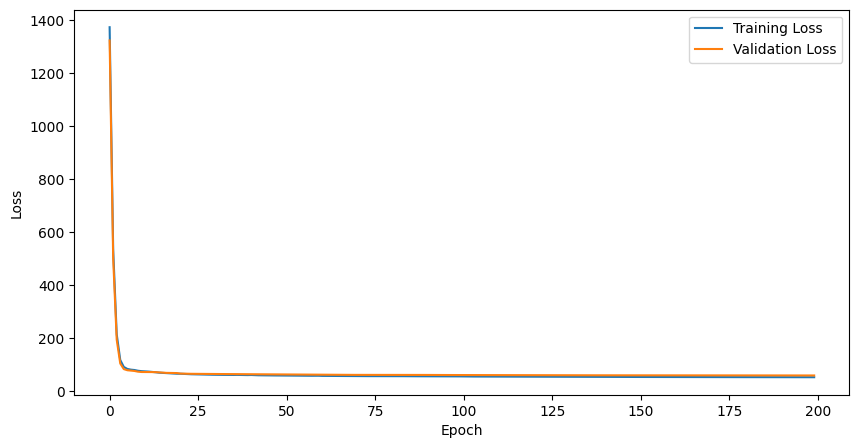

In [11]:
# plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label="Training Loss")
plt.plot(valdation_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Prediction

In [12]:
testfilename = "1034-121119-0049.wav"

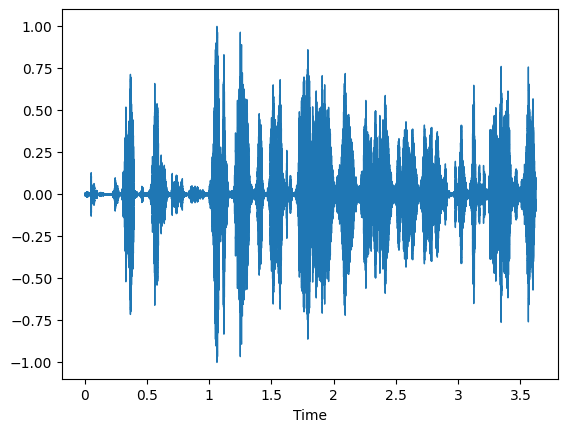

In [13]:
# CLEAN
waveform, sample_rate = librosa.load(''.join([clean_dir, testfilename]))

clean_mel = clean_mel_spectrograms[0]
clean_output = clean_mel.squeeze(0).squeeze(0).detach().numpy()
clean_output = librosa.db_to_power(clean_output)

audio_signal = librosa.feature.inverse.mel_to_audio(clean_output, sr=sample_rate, n_iter=500)
audio_signal = audio_signal / np.max(np.abs(audio_signal))


librosa.display.waveshow(audio_signal, sr=sample_rate)
soundfile.write('test_librosa_clean.wav', audio_signal, sample_rate)

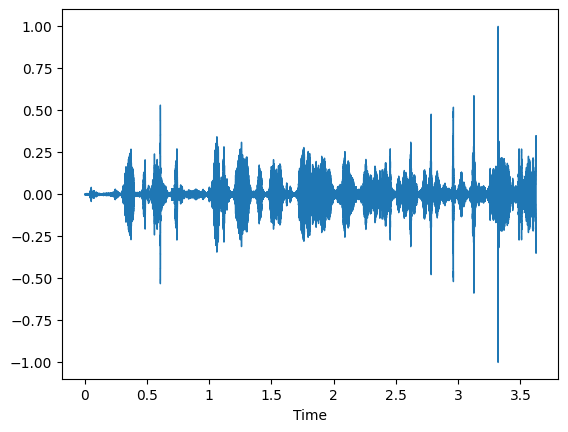

In [14]:
# MIXED
waveform, sample_rate = librosa.load(''.join([mixed_dir, testfilename]))

mixed_mel = mixed_mel_spectrograms[0]
mixed_output = mixed_mel.squeeze(0).squeeze(0).detach().numpy()
mixed_output = librosa.db_to_power(mixed_output)

audio_signal = librosa.feature.inverse.mel_to_audio(mixed_output, sr=sample_rate, n_iter=500)
audio_signal = audio_signal / np.max(np.abs(audio_signal))


librosa.display.waveshow(audio_signal, sr=sample_rate)
soundfile.write('test_librosa_mixed.wav', audio_signal, sample_rate)

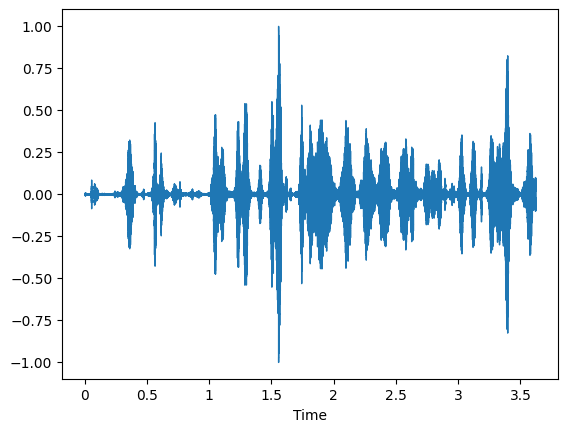

In [15]:
# DENOISED
model.eval()  # 设置模型为评估模式

denoised_output = model(mixed_mel_spectrograms[0].unsqueeze(0))
denoised_output = denoised_output.squeeze(0).squeeze(0).detach().numpy()
denoised_output = librosa.db_to_power(denoised_output)

audio_signal = librosa.feature.inverse.mel_to_audio(denoised_output, sr=sample_rate, n_iter=500)
audio_signal = audio_signal / np.max(np.abs(audio_signal))

librosa.display.waveshow(audio_signal, sr=sample_rate)
soundfile.write('test_librosa_denoised.wav', audio_signal, sample_rate)
